In [1]:
# -------------------
# Imports and Setup
# -------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
import joblib

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(exist_ok=True)

# Load the Data
df = pd.read_csv("../Neural Network for Volatility Forecasting/data/processed/features.csv", index_col=0, parse_dates=True)

baseline_preds = pd.read_csv("../Neural Network for Volatility Forecasting/data/processed/baseline_predictions.csv", index_col=0, parse_dates=True)

returns = df["returns"]

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [19]:
# ----------------
# Model Alignment
# ----------------

lstm_pred = pd.read_csv(
    "../Neural Network for Volatility Forecasting/data/processed/lstm_predictions.csv",
    index_col=0,
    parse_dates=True
)

portfolio_df = df.join(lstm_pred, how="inner")
portfolio_df = portfolio_df.join(baseline_preds[["garch_vol"]], how="inner")

# Alignment
portfolio_df = pd.DataFrame({
    "returns": returns,
    "realized_vol": df["target_vol"],
    "garch_vol": baseline_preds["garch_vol"],
    "lstm_vol": lstm_pred["lstm_vol"]  # adjust depending on storage
}).dropna()

# Set Target
TARGET_VOL = 0.15  # 15% annualized

In [25]:
# -----------------------
# Modeling Calculations
# -----------------------

# Weight Calculations
for model in ["realized_vol", "garch_vol", "lstm_vol"]:
    portfolio_df[f"{model}_weight"] = TARGET_VOL / portfolio_df[model]
    
    # Cap leverage
    portfolio_df[f"{model}_weight"] = portfolio_df[f"{model}_weight"].clip(0, 3)

# Strategic Returns
for model in ["realized_vol", "garch_vol", "lstm_vol"]:
    portfolio_df[f"{model}_strategy"] = (
        portfolio_df[f"{model}_weight"] * portfolio_df["returns"]
    )

# Buy and Hold
portfolio_df["buy_hold"] = portfolio_df["returns"]

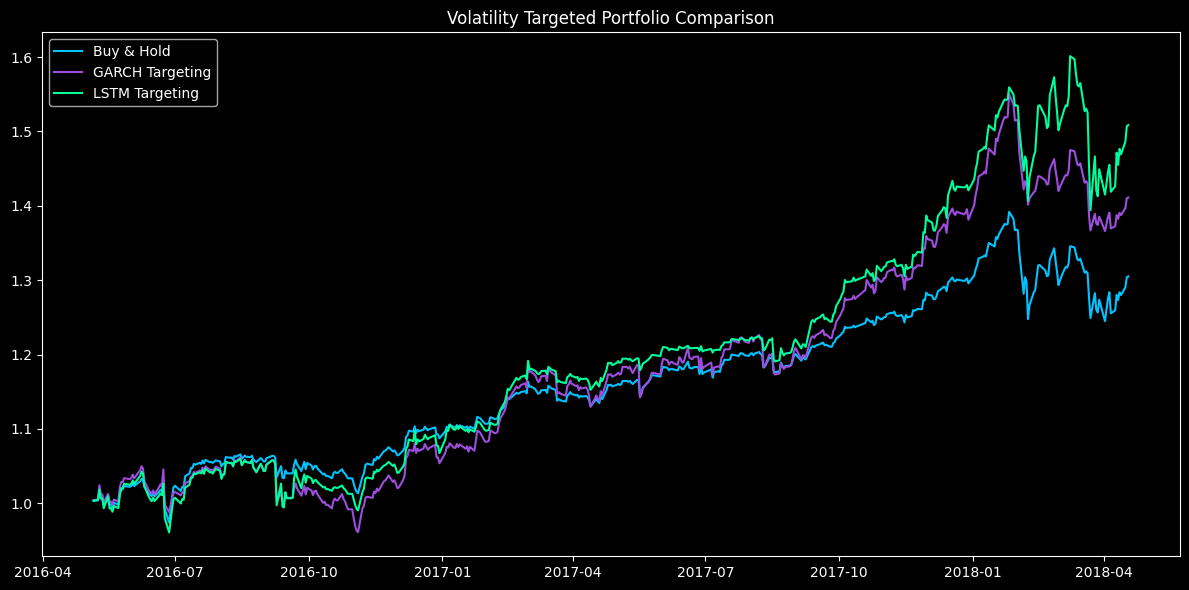

In [27]:
# -------------------
# Cumulative Returns
# -------------------

# Cumulative Returns
cum_df = (1 + portfolio_df[[
    "buy_hold",
    "realized_vol_strategy",
    "garch_vol_strategy",
    "lstm_vol_strategy"
]]).cumprod()

# Visual
plt.figure(figsize=(12,6))

plt.plot(cum_df["buy_hold"], label="Buy & Hold", color=STONKS_BLUE)
plt.plot(cum_df["garch_vol_strategy"], label="GARCH Targeting", color=STONKS_PURP)
plt.plot(cum_df["lstm_vol_strategy"], label="LSTM Targeting", color=STONKS_GREEN)

plt.legend()
plt.title("Volatility Targeted Portfolio Comparison")
plt.tight_layout()
plt.savefig(FIG_DIR / "vol_targeting_comparison.png", dpi=150)
plt.show()

In [31]:
# --------------------
# Performance Metrics
# --------------------

def performance_metrics(returns):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    
    max_dd = drawdown.min()
    
    return ann_return, ann_vol, sharpe, max_dd

# Evaluate
metrics = {}

for strat in [
    "buy_hold",
    "garch_vol_strategy",
    "lstm_vol_strategy"
]:
    metrics[strat] = performance_metrics(portfolio_df[strat])

pd.DataFrame(metrics, index=["Return", "Vol", "Sharpe", "MaxDD"])

# Save Results
pd.DataFrame(metrics, index=["Return", "Vol", "Sharpe", "MaxDD"]).to_csv("../Neural Network for Volatility Forecasting/data/processed/portfolio_results.csv")